# A joint multilevel model for CAR 
Using MVS.CARLeroux
## Common Markov Gaussian Random Field
 $$ [P , S ] = [P | GMRF_p] [ S | GMRF_s] $$

In [2]:
## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')
rm(list=ls())                                                                                     
source("init_data.R")

In [3]:
## Extract the response variables
Y = TDF %>% select(Pinophyta,Abies)
## Extract the formula
formula_presence
rhs <- ~ Elevationm + MeanTempm
X <- model.frame(rhs,DataFrame,na.action='na.pass')

species ~ Elevationm + MeanTempm

In [4]:
K = dim(M_bis)[1]
trials <- matrix(rep(1.0,K*2), ncol=2)

In [5]:
burnin = 50000
n.sample = 100000
thin = 50
model3 <- MVS.CARleroux(cbind(Pinophyta,Abies) ~ Elevationm + MeanTempm, 
                        family = 'binomial',
                        trials=trials,
                        W=M_bis,
                        rho = 1,
                        burnin = burnin,
                        n.sample = n.sample,
                        data = DataFrame
                         )

Setting up the model.
Generating 50000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  4883.9 seconds.


In [6]:
## model
model3$modelfit

DIC           p.d          WAIC           p.w          LMPL 
    1362.7102      526.4155     1386.4110      398.7824     -878.9701 
loglikelihood 
    -154.9396

In [104]:
model3$summary.results

Median   2.5%     97.5%    n.sample % accept
Pinophyta - (Intercept) -11.7569 -21.2189  -8.8901 50000     46.7   
Pinophyta - Elevationm    0.0002  -0.0005   0.0011 50000     46.7   
Pinophyta - MeanTempm    -0.0009  -0.0025   0.0000 50000     46.7   
Abies - (Intercept)     -32.1528 -49.5658 -23.3489 50000     46.7   
Abies - Elevationm        0.0014  -0.0004   0.0038 50000     46.7   
Abies - MeanTempm        -0.0006  -0.0028   0.0012 50000     46.7   
Sigma11                 101.4841  56.0898 366.6597 50000    100.0   
Sigma22                 226.7696 124.2439 618.7947 50000    100.0   
rho                       1.0000   1.0000   1.0000    NA       NA   
                        n.effective Geweke.diag
Pinophyta - (Intercept)  12.1        1.3       
Pinophyta - Elevationm  199.8        0.8       
Pinophyta - MeanTempm    82.9        1.9       
Abies - (Intercept)      27.6        8.7       
Abies - Elevationm      371.8       -3.4       
Abies - MeanTempm       184.4        1.2       
Sigma11                   3.1       -0.8       
Sigma22                   3.6       -2.1       
rho                        NA         NA

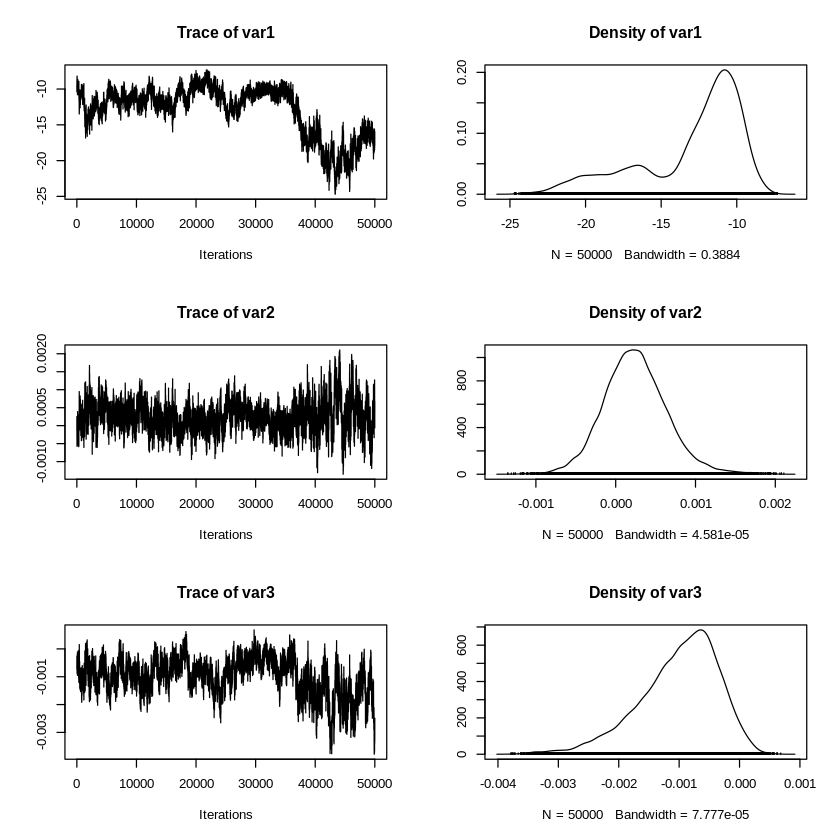

In [105]:
plot(model3$samples$beta)

## Generate datasets. several columns for summary stats

In [7]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}

In [8]:
sample_fitted <- t(model3$samples$fitted)

In [16]:
nK <- dim(TDF)[1]
sS <- sample_fitted[1:nK,]
sP <- sample_fitted[(nK +1) : (2*nK), ]
S <- getUpperLowerCI(sS)
P <- getUpperLowerCI(sP)

In [17]:
sample_phi <- t(model3$samples$phi)
sPhiS <- sample_phi[1:nK,]
sPhiP <- sample_phi[(nK +1) : (2*nK), ]
PhiS <- getUpperLowerCI(sPhiS)
PhiP <- getUpperLowerCI(sPhiP)

## Sample the posterior

In [19]:
post.sample_p = data.frame(model3$samples$fitted)
pss  <- post.sample_p %>% mutate_all(function(p) rbernoulli(1,p))
## divide samples for S and P according to the order given up
pred.S <- pss[,1:nK]
pred.P <- pss[,(nK +1) : (2*nK) ]
sumps <- colSums(pred.S)
sumpp <- colSums(pred.P)
nsample <- nrow(pred.S)
PX <- sumps / nsample

#nsample <- nrow(pred.P)
PY <- sumpp / nsample
PXY <- PX * PY
samples <- cbind(PX,PY,PXY)

## Save fitted samples (P,S)

In [106]:
sample_fitted <- t(model3$samples$fitted)
fitted_chain <- cbind(TDF$cellids,sample_fitted)
file2 <- '/outputs/presence_only_models/modelCAR_model3_fitted_sample.csv'
write.csv(fitted_chain,file2)

In [107]:
sample_phi <- t(model3$samples$phi)
nK <- dim(TDF)[1]

S <- sample_phi[1:nK,]
P <- sample_phi[(nK +1) : (2*nK), ]
chain = cbind(TDF$cellids,S)
file_ = '/outputs/presence_only_models/modelCAR_model3_phi_S.csv'
write.csv(chain,file_)
chain = cbind(TDF$cellids,P)
file_ = '/outputs/presence_only_models/modelCAR_model3_phi_P.csv'
write.csv(chain,file_)


 num [1:4060] 5.30e-05 1.89e-05 2.16e-07 2.14e-06 2.15e-06 ...


In [109]:
## P and S
## divide samples for S and P according to the order given up
nK <- dim(TDF)[1]
fitted = model3$fitted.values
S <- fitted[1:nK]
P <- fitted[(nK +1) : (2*nK) ]
chain = cbind(TDF$cellids,S,P)
file_ = '/outputs/presence_only_models/modelCAR_model3_fitted.csv'
write.csv(chain,file_)


In [110]:
str(model3$samples$Sigma)

 num [1:50000, 1:2, 1:2] 60 60.8 58.7 61.4 57.5 ...


In [111]:
plot(model3$samples$Sigma)